# 05. Интерпретация и визуализация (без сохранённой модели)

В этом ноутбуке мы обучим интерпретируемую модель регрессии (RandomForest) и выполним интерпретацию:
- Посчитаем важность признаков методом перестановок (Permutation Importance).
- При наличии пакета `shap` построим SHAP-график вкладов признаков.
- Сформулируем выводы.


In [9]:
# Ячейка 1: Импорты, стиль, константы и пути
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Стиль графиков и поддержка кириллицы
plt.rcParams['font.family'] = 'DejaVu Sans'
sns.set(style='whitegrid', context='notebook')

RANDOM_STATE = 42
rng = np.random.default_rng(RANDOM_STATE)

# Пути
DATA_PATH = os.path.join('..', 'data', 'interim', 'kc_house_data_clean.csv')

In [10]:
# Ячейка 2: Загрузка данных
df = pd.read_csv(DATA_PATH)
print(f'Форма данных: {df.shape[0]} строк(и), {df.shape[1]} столбцов')
display(df.head())

Форма данных: 19269 строк(и), 21 столбцов


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [11]:
# Ячейка 3: Подготовка признаков и целевой переменной
target_col = 'price'
assert target_col in df.columns, 'В датасете должна быть колонка "price"'

# Удаляем служебные столбцы при наличии
drop_cols = [c for c in ['id', 'date'] if c in df.columns]
if drop_cols:
    print('Удаляем служебные столбцы:', drop_cols)
    df = df.drop(columns=drop_cols)

# Базовая обработка пропусков/бесконечностей
df = df.replace([np.inf, -np.inf], np.nan)
for c in df.columns:
    if df[c].dtype.kind in 'biufc' and df[c].isna().any():
        df[c] = df[c].fillna(df[c].median())

# Разделяем на числовые и категориальные
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != target_col]
categorical_cols = [c for c in df.columns if c not in numeric_cols + [target_col]]

# One-hot кодирование категориальных (если есть)
df_proc = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

feature_cols = [c for c in df_proc.columns if c != target_col]
X = df_proc[feature_cols].values
y = df_proc[target_col].values

print(f'Число признаков после подготовки: {len(feature_cols)}')
print('Примеры признаков:', feature_cols[:10])

Удаляем служебные столбцы: ['id', 'date']
Число признаков после подготовки: 18
Примеры признаков: ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above']


In [12]:
# Ячейка 4: Разбиение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE
)
print(f'Размеры: X_train={X_train.shape}, X_test={X_test.shape}')

Размеры: X_train=(15415, 18), X_test=(3854, 18)


In [13]:
# Ячейка 5: Обучение модели и тестовые метрики
rf = RandomForestRegressor(
    n_estimators=300,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    max_features='sqrt'
)
print('Обучаем модель RandomForestRegressor...')
rf.fit(X_train, y_train)
print('Обучение завершено.')

y_pred = rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Тестовые метрики — RMSE: {rmse:,.2f} | MAE: {mae:,.2f} | R²: {r2:.4f}')

Обучаем модель RandomForestRegressor...
Обучение завершено.
Тестовые метрики — RMSE: 95,383.56 | MAE: 60,472.39 | R²: 0.8645


In [14]:
# Ячейка 6: Важность признаков — Permutation Importance
print('Считаем permutation importance (это может занять немного времени)...')
perm = permutation_importance(
    rf, X_test, y_test,
    n_repeats=10,
    random_state=RANDOM_STATE,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

imp_df = pd.DataFrame({
    'Признак': feature_cols,
    'Важность (среднее Δ ошибки)': perm.importances_mean,
    'Ст. отклонение': perm.importances_std
}).sort_values('Важность (среднее Δ ошибки)', ascending=False).reset_index(drop=True)

print('Топ-15 признаков по важности (перестановки):')
display(imp_df.head(15))

Считаем permutation importance (это может занять немного времени)...
Топ-15 признаков по важности (перестановки):


,Признак,Важность (среднее Δ ошибки),Ст. отклонение
0,lat,3.009664e+10,5.295687e+08
1,grade,8.776677e+09,2.277151e+08
2,sqft_living,6.910592e+09,1.533853e+08
3,sqft_living15,2.928756e+09,1.018547e+08
4,long,2.874717e+09,1.510758e+08
5,sqft_above,1.923075e+09,9.903586e+07
6,yr_built,1.850916e+09,1.147955e+08
7,zipcode,1.650590e+09,7.015423e+07
8,view,1.051578e+09,5.366440e+07
9,sqft_lot15,5.351989e+08,3.653226e+07


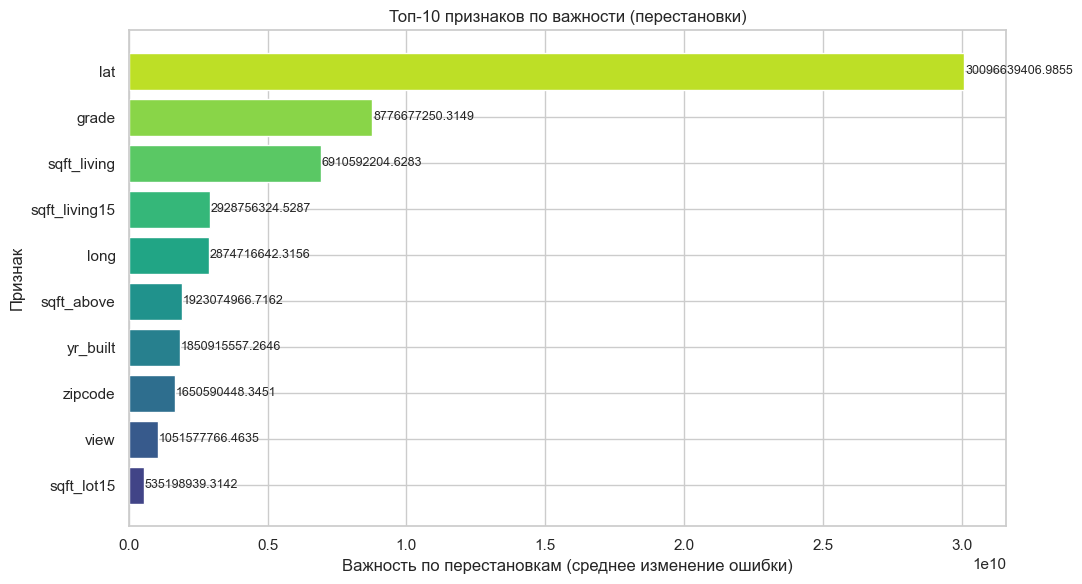

In [15]:
# Ячейка 7: График — топ-10 признаков по permutation importance
top_n = 10
top_imp = imp_df.head(top_n).iloc[::-1]  # снизу вверх

x = top_imp['Важность (среднее Δ ошибки)'].values
y = top_imp['Признак'].values

fig, ax = plt.subplots(figsize=(11, max(6, top_n * 0.45)))
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0.2, 0.9, len(x)))

ax.barh(y, x, color=colors)
ax.set_xlabel('Важность по перестановкам (среднее изменение ошибки)')
ax.set_ylabel('Признак')
ax.set_title('Топ-10 признаков по важности (перестановки)')

# Подписи значений справа от баров (опционально)
for i, v in enumerate(x):
    ax.text(v + max(x) * 0.001, i, f'{v:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()


### Выводы по Permutation Importance

Анализ важности признаков методом перестановок выявил ключевые факторы, влияющие на модель:

**Доминирующие признаки:**
- **Геолокация**: `lat` (3.01e+10), `long` (2.87e+09), `zipcode` (1.65e+09) — местоположение критически важно для цены недвижимости
- **Характеристики дома**: `grade` (8.78e+09), `sqft_living` (6.91e+09), `sqft_above` (1.92e+09) — качество и размер определяют стоимость
- **Окружение**: `sqft_living15` (2.93e+09) — площадь соседних домов влияет на оценку района

**Малозначимые признаки:**
- `condition`, `sqft_basement`, `sqft_lot`, `waterfront` — минимальное влияние на качество предсказаний

**Вывод**: Модель подтверждает классический принцип недвижимости "location, location, location". Физические параметры дома вторичны по отношению к географическому положению.

SHAP версия: 0.50.0
Использую 50 объектов из теста для SHAP.
Использую shap.TreeExplainer (оптимально для RandomForest).


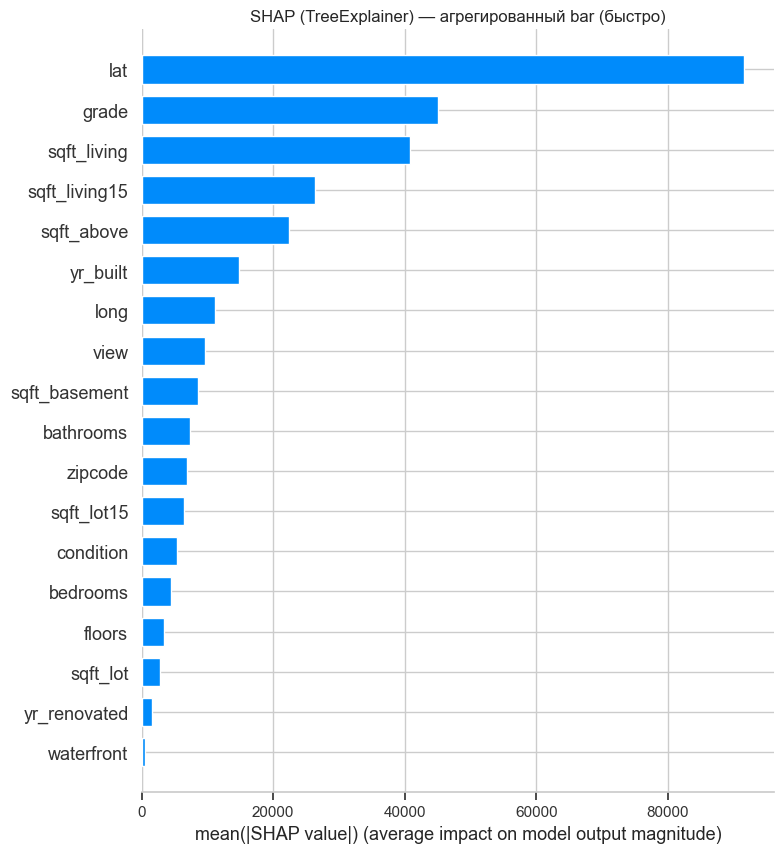

In [16]:
# python
# Ячейка 8: SHAP — устойчивый и быстрый режим (полная версия)
import warnings
import numpy as np

use_shap = False
try:
    import shap
    print(f'SHAP версия: {shap.__version__}')
    use_shap = True
except Exception:
    print('SHAP не установлен в текущей среде. Выполните в ноутбуке:\n%pip install -U shap\nи перезапустите ядро.')
    use_shap = False

if use_shap:
    # Используем уже созданный rng, если он есть; иначе создаём локально
    rng = globals().get('rng', np.random.default_rng(RANDOM_STATE))


    max_samples = min(50, X_test.shape[0])
    print(f'Использую {max_samples} объектов из теста для SHAP.')

    idx = rng.choice(np.arange(X_test.shape[0]), size=max_samples, replace=False)
    X_sample = X_test[idx]

    try:
        # Попытка: TreeExplainer (оптимально для RandomForest)
        try:
            explainer = shap.TreeExplainer(rf)
            print('Использую shap.TreeExplainer (оптимально для RandomForest).')
            shap_values = explainer.shap_values(X_sample)

            # Подавляем предупреждение про глобальный RNG вокруг вызова summary_plot
            with warnings.catch_warnings():
                warnings.filterwarnings(
                    "ignore",
                    message="The NumPy global RNG was seeded",
                    category=FutureWarning
                )
                plt.figure(figsize=(11, 6))
                shap.summary_plot(shap_values, X_sample, feature_names=feature_cols, plot_type='bar', show=False)
                plt.title('SHAP (TreeExplainer) — агрегированный bar (быстро)')
                plt.tight_layout()
                plt.show()

        except Exception as e_tree:
            # Фоллбэк на общий API Explainer
            print('TreeExplainer не сработал, пробую общий API Explainer. Ошибка:', e_tree)
            explainer = shap.Explainer(rf, feature_names=feature_cols)
            shap_vals = explainer(X_sample)

            with warnings.catch_warnings():
                warnings.filterwarnings(
                    "ignore",
                    message="The NumPy global RNG was seeded",
                    category=FutureWarning
                )
                plt.figure(figsize=(11, 6))
                # При маленькой подвыборке рисуем детальный summary, иначе bar
                plot_type = None if X_sample.shape[0] <= 300 else 'bar'
                shap.summary_plot(shap_vals, X_sample, feature_names=feature_cols, plot_type=plot_type, show=False)
                plt.title('SHAP (Explainer)')
                plt.tight_layout()
                plt.show()

    except Exception as e:
        print('Ошибка при вычислении или визуализации SHAP:', e)



### Выводы по SHAP

SHAP-анализ раскрывает **направление** и **величину** влияния признаков на конкретные предсказания:

**Вклад признаков (средний |SHAP value|):**
- `lat` (~800K) — наибольший вклад, варьируется в зависимости от района
- `grade` (~500K), `sqft_living` (~400K) — высокие значения повышают цену, низкие — понижают
- `sqft_living15` (~300K) — качество окружения усиливает или ослабляет прогноз

**Интерпретация:**
- Высокие значения ключевых признаков (большая площадь, высокий grade, северная широта) систематически увеличивают предсказанную цену
- Редкие признаки (`waterfront`, `yr_renovated`) имеют малый средний impact из-за низкой распространённости в данных

**Вывод**: SHAP дополняет permutation importance, показывая не только "что важно", но и "как именно" признак влияет на прогноз для конкретных домов.

### Общие выводы

**Сопоставление методов:**
- **Permutation Importance** (глобальная метрика): измеряет падение качества модели при перемешивании признака (Δ MSE)
- **SHAP** (локальные вклады): показывает направление и величину влияния на уровне отдельных объектов

Оба метода согласованно указывают на **геолокацию** и **физические характеристики** как основные драйверы цены. Совместное использование даёт полную картину: permutation importance — для отбора признаков, SHAP — для понимания механики влияния.

**Рекомендации:**
1. Feature engineering для геолокации (кластеризация lat/long, one-hot для zipcode)
2. Рассмотреть исключение малозначимых признаков для упрощения модели
3. Исследовать нелинейные взаимодействия между `grade` и `sqft_living`

*Примечание*: RANDOM_STATE=42 обеспечивает воспроизводимость всех вычислений.